In [1]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("train.csv")

In [3]:
data

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0
...,...,...,...
3995,every time i try to edit a page or create a li...,tools,0
3996,unable to load money using wallets (phonepe/ol...,Unable to load money using wallets,0
3997,"hi, i m doing for the first time ever and i no...",usage,0
3998,delivery is delayed or cancelled every time i ...,Delivery,0


<AxesSubplot:xlabel='label', ylabel='count'>

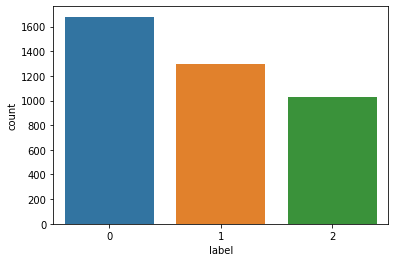

In [4]:
sns.countplot(x='label', data=data)

In [5]:
ps = PorterStemmer()
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext
data['text'] = data['text'].apply(clean_text)
data['aspect'] = data['aspect'].apply(clean_text)

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])

In [7]:
tokenized_text = tokenizer.texts_to_sequences(data['text'])
tokenized_aspect = tokenizer.texts_to_sequences(data['aspect'])

In [8]:
embedded_text=pad_sequences(tokenized_text,padding='pre',maxlen=120)
print(embedded_text)

embedded_aspect=pad_sequences(tokenized_aspect,padding='pre',maxlen=8)
print(embedded_aspect)

[[   0    0    0 ...  372   47  228]
 [   0    0    0 ...    3  396   45]
 [   0    0    0 ...    1   53  330]
 ...
 [   0    0    0 ... 1791  441    1]
 [   0    0    0 ...    5   70  248]
 [   0    0    0 ...   29   13  484]]
[[   0    0    0 ...    0    0   47]
 [   0    0    0 ...    0    0   22]
 [   0    0    0 ...    0    0  218]
 ...
 [   0    0    0 ...    0    0 1791]
 [   0    0    0 ...    0    0    3]
 [   0    0    0 ...    0   29   13]]


In [9]:
len(embedded_text),len(embedded_aspect),data['label'].shape

(4000, 4000, (4000,))

In [10]:
X1=np.array(embedded_text)
X2=np.array(embedded_aspect)
y=np.array(data['label'])

In [11]:
input_1 = Input(shape=(120,))

input_2 = Input(shape=(8,))

In [12]:
embedding_layer_1 = Embedding(5000, 120)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer_1)

In [13]:
embedding_layer_2 = Embedding(5000, 8)(input_2)
LSTM_Layer_2 = LSTM(32)(embedding_layer_2)

In [14]:
concat_layer = Concatenate()([LSTM_Layer_1, LSTM_Layer_2])
dense_layer_1 = Dense(15, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_1)
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 120, 120)     600000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8, 8)         40000       input_2[0][0]                    
______________________________________________________________________________________________

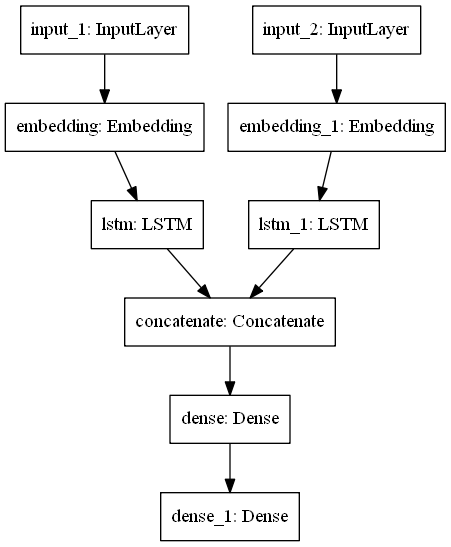

In [16]:
tf.keras.utils.plot_model(model)

In [17]:
X1.shape

(4000, 120)

In [18]:
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1,X2, y, test_size=0.1, random_state=42)
print('Train text data len:'+str(len(X1_train)))
print('Train aspect data len:'+str(len(X2_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print()
print('Test text data len:'+str(len(X1_test)))
print('Test aspect data len:'+str(len(X2_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train text data len:3600
Train aspect data len:3600
Class distribution
0    1501
1    1170
2     929
dtype: int64

Test text data len:400
Test aspect data len:400
Class distribution
0    179
1    124
2     97
dtype: int64


In [19]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=72, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
40/40 [==============================] - 19s 345ms/step - loss: 1.0573 - acc: 0.4542 - val_loss: 0.9855 - val_acc: 0.5028
Epoch 2/3
40/40 [==============================] - 11s 278ms/step - loss: 0.8211 - acc: 0.6368 - val_loss: 0.8078 - val_acc: 0.6319
Epoch 3/3
40/40 [==============================] - 11s 272ms/step - loss: 0.5663 - acc: 0.7771 - val_loss: 0.8293 - val_acc: 0.6611


In [21]:
loss,accuracy=model.evaluate([X1_test,X2_test],y_test)

print('Accuracy: {}'.format(round(accuracy,2)))
print('Loss: {}'.format(round(loss,2)))

13/13 [==============================] - 2s 56ms/step - loss: 0.7811 - acc: 0.6950
Accuracy: 0.69
Loss: 0.78


In [22]:
model.predict([X1_test,X2_test])

array([[0.34756294, 0.6308411 , 0.02159593],
       [0.95379174, 0.01600494, 0.03020321],
       [0.24044469, 0.00332157, 0.7562337 ],
       ...,
       [0.55241996, 0.43770596, 0.00987406],
       [0.11546436, 0.6931655 , 0.19137025],
       [0.05473153, 0.9180087 , 0.02725986]], dtype=float32)

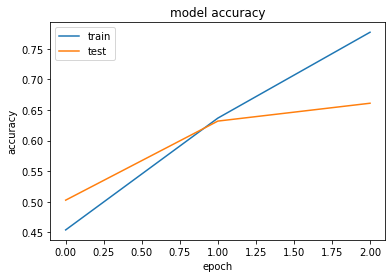

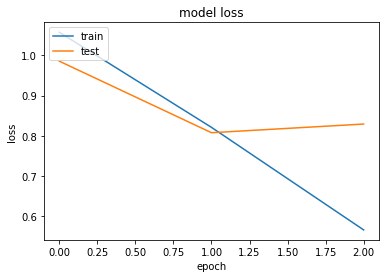

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()